<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Елена Девятайкина (@elenadevyataykina)

# Оценка плотности, используя Gaussian Mixture Models

В данном курсе были рассмаотрены следующие алгоритмы кластеризации: 
- K-means

- Affinity Propagation

- Спектральная кластеризация

- Агломеративная кластеризация

Здесь будет рассмотрен EM-алгоритм, реализованный в модуле `sklearn.mixture.GMM`.

**Что это такое?**

Это алгоритм, используемый для нахождения оценок максимального правдоподобия параметров вероятностных моделей, в случае, когда модель зависит от некоторых скрытых переменных.

**Как он работает?**

Оценивая максимальное правдоподобие, EM-алгоритм создает модель, которая назначает метки класса точкам данных.

EM-алгоритм начинает с того, что пытается сделать вывод на основании параметров модели.

Затем следует итерационный трехшаговый процесс:

1. E-шаг: На этом шаге на основании параметров модели вычисляются вероятность принадлежности каждой точки данных к кластеру.
2. М-шаг: Обновляет параметры модели в соответствии с кластерным распределением, проведенным на шаге E.
3. Предыдущие два шага повторяются до тех пор, пока параметры модели и кластерное распределение не уравняются.

Часто данный алгоритм используют для разделения смеси гаусиан (GMM). То есть в результате GMM-EM получаем полноценную смесь Гауссианов полученную в локальном максимуме правдоподобия.

Далее рассмаотрим GMM более подробно.


**GMM** - один из алгоритмов кластеризации наряду с иерархической кластеризацией (кластеризация на основе связности), k-means (кластеризация на основе центров), DBSCAN (кластеризация на основе плотности). В основе данного алгоритма лежат распределения. 

**Гауссова смесь распределений (GMM — Gaussian mixture models)** - статистическая модель для представления нормально распределенных подвыборок внутри общей выборки. Гауссова смесь распределений параметризируется двумя типами значений — смесь весов компонентов и средних компонентов или ковариаций (для многомерного случая) и др. Если количество компонентов известно, техника, чаще всего используемая для оценки параметров смеси распределений — ЕМ-алгоритм.

Метод GMM непосредственно вытекает из теоремы, гласящей, что любая функция плотности вероятности может быть представлена как взвешенная сумма нормальных распределений

$$
p = \sum_{j=1}^k w_i \varphi (x; \theta_j),$$

$$
\sum_{j=1}^k w_j = 1,$$
где $\varphi (x; \theta_j)$ - функция распределения многомерного аргумента $x$ с параметрами $\theta_j,$ 

$$\varphi (x; \theta_j) = p(x | \mu_j, R_j) = \frac{1}{{2\pi}^{n/2}{|R_j|}^{1/2}}e^{-\frac{1}{2}{(x-\mu_j)}^TR_j^{-1}(x-\mu_j)},  x \in \mathbb R^n$$

$w_j$ - ее вес, $k$ - количество компонент в смеси. Здесь $n$ - размерность пространства признаков, $\mu_j \in \mathbb R^n$ - вектор математического ожидания $j$-й компоненты смеси, $R_j \in \mathbb R^{n*n}$ - ковариационная матрица.


In [34]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns; sns.set()

from sklearn.mixture import GMM
from sklearn.neighbors import KernelDensity

## Введение в GMM

Создадим одномерный набор данных с азаднным распределением и построим гистограмму

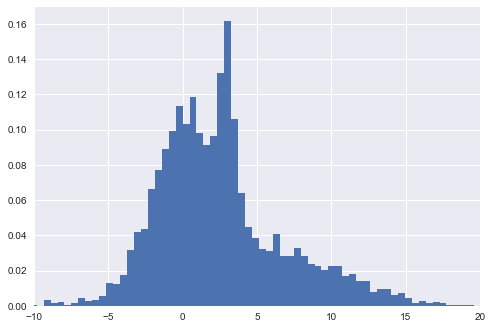

In [2]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

С помощью GMM отобразим плотность распределения

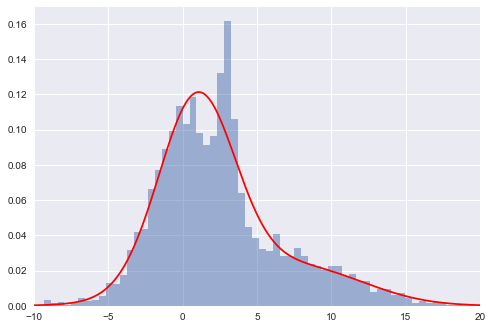

In [35]:
X = x[:, np.newaxis]
clf = GMM(4, n_iter=500, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Посмотрим на полученные атрибуты GMM.

Среднее значение каждой компоненты:

In [5]:
clf.means_

array([[ 0.25306823],
       [ 3.96038601],
       [ 1.45350312],
       [ 9.56303626]])

Ковариация каждой компоненты

In [6]:
clf.covars_

array([[  6.4601766 ],
       [ 23.19014431],
       [  5.80884786],
       [ 14.79998213]])

Вес каждой компоненты

In [7]:
clf.weights_

array([ 0.31823886,  0.21876416,  0.35341345,  0.10958354])

Так как в GMM задано 4 компоненты, построим все плотности распределения

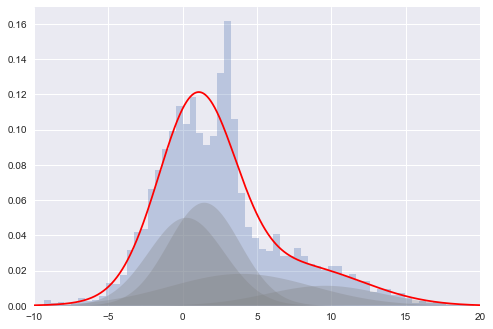

In [8]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

Для построенной модели можно использовать одно из нескольких средних, чтобы оценить, насколько хорошо он подходит данным.
Обычно для этого используется **Информационный критерий Акаике (AIC)** или **Байесовский информационный критерий (BIC)**.

**Информационный критерий Акаике** - критерий, применяющийся исключительно для выбора из нескольких статистических моделей.

$$aic = 2k - 2l,$$

где $k$ - число параметров в статистической модели, $l$ - значение логарифмической функции правдоподобия построенной модели.
Критерий не только вознаграждает за качество приближения, но и штрафует за использование излишнего количества параметров модели. Считается, что наилучшей будет модель с наименьшим значением критерия aic.

**Байесовский информационный критерий** - критерий, разработанный исходя из баесовского подхода, модификация aic.

$$bic = k ln(n) - 2l$$

Данный критерий налагает больший штраф на увеличение количества параметров по сравнению с aic.

Посмотрим на значение aic, bic на заданной выборке

In [36]:
print(clf.bic(X))
print(clf.aic(X))

25911.1937804
25840.421853


Давайте рассмотрим их как функцию числа гауссиан:

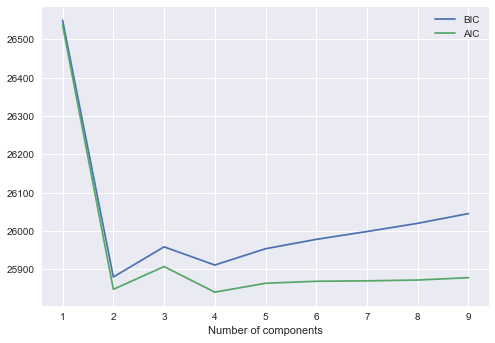

In [37]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, n_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.xlabel('Number of components')
plt.legend();

Судя по графику можно сказать, что для aic предпочтительнее 4 компоненты, а для bic - 2

Так как GMM является Generative Model(вероятностная модель для генерации набора данных). С помощью даннной модели можно обнаружить выбросы (Рассчитывается вероятность каждой точки под моделью и чем ниже $p(x)$, тем вероятнее, что данная точка является выбросом. Есть подробная статья, связанная с этой темой - https://arxiv.org/pdf/1706.02690.pdf)

In [24]:
np.random.seed(0)

# Добавим к выборке 20 выбросов
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

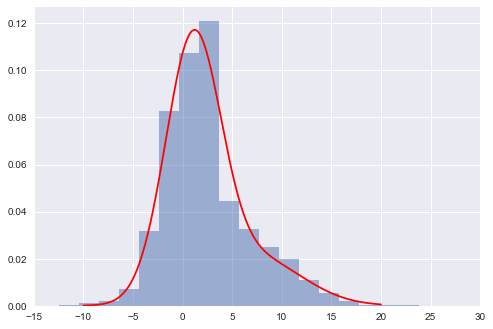

In [38]:
clf = GMM(4, n_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(y, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

Далее оценим логарифмическую вероятность каждой точки под моделью

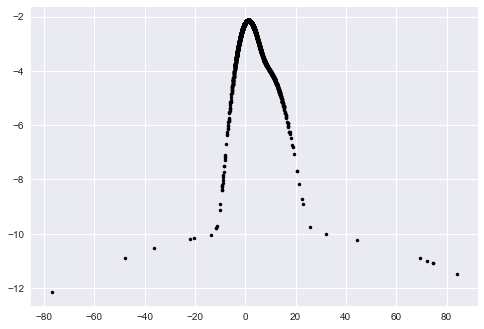

In [39]:
log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [27]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("Все выбросы:")
print(true_outliers)
print("\nОбнаруженные выбросы:")
print(detected_outliers)

Все выбросы:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607 2732
 2893 2897 3264 3468 4373]

Обнаруженные выбросы:
[  99  537  705 1653 2046 2135 2163 2222 2496 2732 2893 2897 3067 3173 3253
 3468 3483 4373]


Как можно заметить, алгоритм пропустил несколько точек (те, которые находятся в середине распределения).

Вот пропущенные выбросы:

In [29]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

И вот значения, которые были неверно определены как выбросы

In [31]:
set(detected_outliers) - set(true_outliers)

{3067, 3173, 3253, 3483}

Необходимо отметить, что здесь используются одномерные данные, но GMM также может делать обобщения на несколько измерений.

## Другие оценки плотности

Важным средством оценки плотности является оценка плотности ядра, реализованная в `sklearn.neighbors.KernelDensity`. Можно это рассматривать как обобщение GMM. 

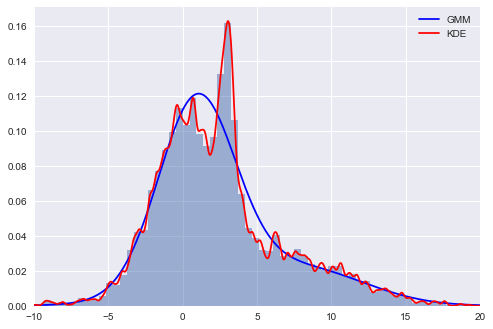

In [17]:
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

Все оценки плотности можно рассматривать как генерирующие модели данных: то есть это позволяет понять, как создавать больше данных, которые соответствуют модели. 